In [1]:
  # Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Sklearn modules & classes
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score, classification_report, recall_score
from sklearn import datasets
from sklearn import metrics

#Logistic
from sklearn.linear_model import LogisticRegression

# ANN
import keras
from keras.models import Sequential
from keras.layers import Dense


# RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

#가우시안 나이브 베이즈
from sklearn.naive_bayes import GaussianNB
np.random.seed(10)

# 모델 저장
from keras.models import load_model
import joblib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the data set
df = pd.read_csv("/content/drive/My Drive/부실기업예측 프로젝트/data/variable.csv", encoding="utf-8")
df.sector = df.sector.apply(lambda x : "manufacture" if x == 2 else "service")
df_dummy = pd.get_dummies(df['sector'])
df = pd.concat([df,df_dummy], axis = 1)
x = df[['x1','x2','x3','x4','om','ga','ge',"gs","manufacture","service"]]
y = df['bankrupt']

In [4]:
# Create training and test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [5]:
# 각 모델 정의
def SVM_model(x_train,y_train,x_test,y_test):
    # 우선 svm의 경우 전부 정규화 과정을 거치도록 입력
    # sc = StandardScaler()
    # sc.fit(x_train)
    # x_train_std = sc.transform(x_train)
    # x_test_std = sc.transform(x_test)
    svc = SVC(C=1.0, random_state=0, kernel='rbf', probability=True)
    
    # # Fit the model

    svc.fit(x_train, y_train)
    svc.score(x_train, y_train)
    test_predict = svc.predict(x_test)
    # Measure the performance
    print("Accuracy score :", accuracy_score(y_test, test_predict))
    print("ROC-AUC : ", roc_auc_score(y_test, test_predict))
    print( "F1-score : ", f1_score(y_test, test_predict))
    print("confusion matrix : \n", confusion_matrix(y_test, test_predict))
    print(classification_report(y_test, test_predict, labels=[0,1]))
    joblib.dump(svc, "/content/drive/My Drive/부실기업예측 프로젝트/pred_model/svc.h5")    
    return svc

def Logistic_model(x_train,y_train,x_test,y_test):
    #logistic model build
    logistic = LogisticRegression(random_state=0,solver="lbfgs")
    logistic.fit(x_train, y_train)

    test_predict = logistic.predict(x_test)

    print(logistic.score(x_train, y_train))
    print("Accuracy score :", accuracy_score(y_test, test_predict))
    print("ROC-AUC : ", roc_auc_score(y_test, test_predict))
    print( "F1-score : ", f1_score(y_test, test_predict))
    print("confusion matrix : \n", confusion_matrix(y_test, test_predict))
    print(classification_report(y_test, test_predict, labels=[0,1]))
    joblib.dump(logistic, "/content/drive/My Drive/부실기업예측 프로젝트/pred_model/logistic.h5")    
    return logistic

def ANN(x_train,y_train,x_test,y_test):
    # Initialising the ANN
    classifier = Sequential()
    # Adding the input layer and the first hidden layer
    classifier.add(Dense(units = 25, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(x_train.columns)))
    # Adding the second hidden layer
    classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
    # Adding the output layer
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    # Compiling the ANN
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    # Fitting the ANN to the Training set
    print(classifier.summary())
    classifier.fit(x_train, y_train, batch_size = 40, epochs = 200)

    y_pred = classifier.predict(x_test)
    y_pred = (y_pred > 0.5)
    cm = confusion_matrix(y_test, y_pred)
    loss, accuracy = classifier.evaluate(x_test, y_test)

    print('Loss : ', loss)
    print('Accuracy : ', accuracy)
    print("Roc-Auc :", roc_auc_score(y_test, y_pred))
    print('F1-Score : ', f1_score(y_test,y_pred))
    print('Confusion Matrix : \n', cm)
    print(classification_report(y_test, y_pred, labels=[0,1]))
    classifier.save("/content/drive/My Drive/부실기업예측 프로젝트/pred_model/ann.h5")    
    return classifier

def RF_model(x_train,y_train,x_test,y_test):
    # RandomForest
    forest_model = RandomForestClassifier(random_state=0, max_depth=50)
    forest_model.fit(x_train, y_train)

    y_predict = forest_model.predict(x_test)

    print(forest_model.score(x_train, y_train))
    print("Accuracy score :", accuracy_score(y_test, y_predict))
    print("ROC-AUC : ", roc_auc_score(y_test, y_predict))
    print( "F1-score : ", f1_score(y_test, y_predict))
    print("confusion matrix : \n", confusion_matrix(y_test, y_predict))
    print(classification_report(y_test, y_predict, labels=[0,1]))
    joblib.dump(forest_model, "/content/drive/My Drive/부실기업예측 프로젝트/pred_model/RF.h5")    
    return forest_model

def Gausian(x_train,y_train,x_test,y_test):
    # 가우시안 나이브 베이즈
    gnb = GaussianNB()                             # 가우시안 나이브 베이즈 모델
    gnb.fit(x_train, y_train)       # 학습 시작
    y_predict = gnb.predict(x_test)             # 학습 결과를 기존 데이터에 적용
    print(gnb.score(x_train, y_train))
    print("Accuracy score :", accuracy_score(y_test, y_predict))
    print("ROC-AUC : ", roc_auc_score(y_test, y_predict))
    print( "F1-score : ", f1_score(y_test, y_predict))
    print("confusion matrix : \n", confusion_matrix(y_test, y_predict))
    print(classification_report(y_test, y_predict, labels=[0,1]))
    joblib.dump(gnb, "/content/drive/My Drive/부실기업예측 프로젝트/pred_model/gnb.h5")    
    return gnb

In [6]:
proba = Gausian(x_train,y_train,x_test,y_test)

0.9491955969517358
Accuracy score : 0.9441624365482234
ROC-AUC :  0.8210673409635347
F1-score :  0.35294117647058826
confusion matrix : 
 [[549  29]
 [  4   9]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       578
           1       0.24      0.69      0.35        13

    accuracy                           0.94       591
   macro avg       0.61      0.82      0.66       591
weighted avg       0.98      0.94      0.96       591



In [7]:
SVM_model(x_train,y_train,x_test,y_test)

Accuracy score : 0.9763113367174281
ROC-AUC :  0.4991349480968858
F1-score :  0.0
confusion matrix : 
 [[577   1]
 [ 13   0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       578
           1       0.00      0.00      0.00        13

    accuracy                           0.98       591
   macro avg       0.49      0.50      0.49       591
weighted avg       0.96      0.98      0.97       591



SVC(probability=True, random_state=0)

In [8]:
Logistic_model(x_train,y_train,x_test,y_test)

0.9767146486028789
Accuracy score : 0.9763113367174281
ROC-AUC :  0.6495208943305829
F1-score :  0.3636363636363637
confusion matrix : 
 [[573   5]
 [  9   4]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       578
           1       0.44      0.31      0.36        13

    accuracy                           0.98       591
   macro avg       0.71      0.65      0.68       591
weighted avg       0.97      0.98      0.97       591



LogisticRegression(random_state=0)

In [9]:
ANN(x_train,y_train,x_test,y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                275       
                                                                 
 dense_1 (Dense)             (None, 15)                390       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 681
Trainable params: 681
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
60/60 [==============================] - 1s 2ms/step - loss: 0.6060 - accuracy: 0.9721
Epoch 2/200
60/60 [==============================] - 0s 1ms/step - loss: 0.2169 - accuracy: 0.9721
Epoch 3/200
60/60 [==============================] - 0s 2ms/step - loss: 0.1119 - accuracy: 0.9721
Epoch 4/200
60/60 [=

In [10]:
RF_model(x_train,y_train,x_test,y_test)

1.0
Accuracy score : 0.9830795262267343
ROC-AUC :  0.6529811019430397
F1-score :  0.4444444444444444
confusion matrix : 
 [[577   1]
 [  9   4]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       578
           1       0.80      0.31      0.44        13

    accuracy                           0.98       591
   macro avg       0.89      0.65      0.72       591
weighted avg       0.98      0.98      0.98       591



RandomForestClassifier(max_depth=50, random_state=0)

In [11]:
#오버 샘플링
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot

In [12]:
x_upper, y_upper = SMOTE(random_state=0).fit_resample(x_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(x_upper.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_upper.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_upper==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_upper==0)))

After OverSampling, the shape of train_X: (4592, 10)
After OverSampling, the shape of train_y: (4592,) 

After OverSampling, counts of label '1': 2296
After OverSampling, counts of label '0': 2296


In [13]:
gas = Gausian(x_upper,y_upper,x_test,y_test)

0.7234320557491289
Accuracy score : 0.9018612521150592
ROC-AUC :  0.79944104338568
F1-score :  0.2368421052631579
confusion matrix : 
 [[524  54]
 [  4   9]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       578
           1       0.14      0.69      0.24        13

    accuracy                           0.90       591
   macro avg       0.57      0.80      0.59       591
weighted avg       0.97      0.90      0.93       591



In [14]:
svc = SVM_model(x_upper,y_upper,x_test,y_test)

Accuracy score : 0.8274111675126904
ROC-AUC :  0.9117647058823529
F1-score :  0.203125
confusion matrix : 
 [[476 102]
 [  0  13]]
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       578
           1       0.11      1.00      0.20        13

    accuracy                           0.83       591
   macro avg       0.56      0.91      0.55       591
weighted avg       0.98      0.83      0.89       591



In [15]:
logistic = Logistic_model(x_upper,y_upper,x_test,y_test)

0.8371080139372822
Accuracy score : 0.8358714043993232
ROC-AUC :  0.9160899653979239
F1-score :  0.21138211382113822
confusion matrix : 
 [[481  97]
 [  0  13]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91       578
           1       0.12      1.00      0.21        13

    accuracy                           0.84       591
   macro avg       0.56      0.92      0.56       591
weighted avg       0.98      0.84      0.89       591



In [16]:
classifier = ANN(x_upper,y_upper,x_test,y_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25)                275       
                                                                 
 dense_4 (Dense)             (None, 15)                390       
                                                                 
 dense_5 (Dense)             (None, 1)                 16        
                                                                 
Total params: 681
Trainable params: 681
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
115/115 [==============================] - 1s 2ms/step - loss: 0.6336 - accuracy: 0.6956
Epoch 2/200
115/115 [==============================] - 0s 2ms/step - loss: 0.4216 - accuracy: 0.8397
Epoch 3/200
115/115 [==============================] - 0s 2ms/step - loss: 0.3638 - accuracy: 0.8539
Epoch 4/200


In [17]:
rf = RF_model(x_upper,y_upper,x_test,y_test)

1.0
Accuracy score : 0.9357021996615905
ROC-AUC :  0.7791455948895395
F1-score :  0.29629629629629634
confusion matrix : 
 [[545  33]
 [  5   8]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       578
           1       0.20      0.62      0.30        13

    accuracy                           0.94       591
   macro avg       0.59      0.78      0.63       591
weighted avg       0.97      0.94      0.95       591



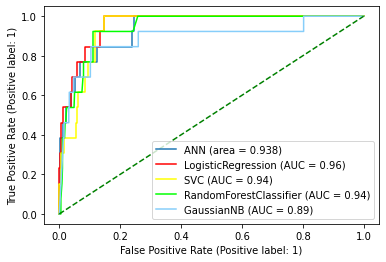

In [18]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
from sklearn.metrics import roc_curve
y_pred_keras = classifier.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

ax.plot(fpr_keras, tpr_keras, label='ANN (area = {:.3f})'.format(auc_keras))
log_disp = RocCurveDisplay.from_estimator(logistic, x_test, y_test, ax = ax, color = "red")
svc_disp = RocCurveDisplay.from_estimator(svc, x_test, y_test, ax = ax, color = "yellow")
rf_disp = RocCurveDisplay.from_estimator(rf, x_test, y_test, ax = ax, color = "lime")
gas_disp = RocCurveDisplay.from_estimator(gas, x_test, y_test, ax = ax, color = "lightskyblue")

plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.savefig('/content/drive/My Drive/부실기업예측 프로젝트/roc1.png')
plt.show()

In [19]:
# UnderSampling # 완전무작위
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
# define dataset
# summarize class distribution
print(Counter(y_train))
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority', random_state = 42)
# fit and apply the transform
x_under, y_under = undersample.fit_resample(x_train, y_train)
# summarize class distribution
print(Counter(y_under))

Counter({0: 2296, 1: 66})
Counter({0: 66, 1: 66})


In [20]:
gas = Gausian(x_under,y_under,x_test,y_test)

0.7348484848484849
Accuracy score : 0.8950930626057529
ROC-AUC :  0.8335773223316475
F1-score :  0.24390243902439027
confusion matrix : 
 [[519  59]
 [  3  10]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       578
           1       0.14      0.77      0.24        13

    accuracy                           0.90       591
   macro avg       0.57      0.83      0.59       591
weighted avg       0.98      0.90      0.93       591



In [21]:
svc = SVM_model(x_under,y_under,x_test,y_test)

Accuracy score : 0.8257191201353637
ROC-AUC :  0.8733031674208145
F1-score :  0.18897637795275588
confusion matrix : 
 [[476 102]
 [  1  12]]
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       578
           1       0.11      0.92      0.19        13

    accuracy                           0.83       591
   macro avg       0.55      0.87      0.55       591
weighted avg       0.98      0.83      0.89       591



In [22]:
logistic = Logistic_model(x_under,y_under,x_test,y_test)

0.8409090909090909
Accuracy score : 0.8341793570219966
ROC-AUC :  0.9152249134948097
F1-score :  0.20967741935483872
confusion matrix : 
 [[480  98]
 [  0  13]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91       578
           1       0.12      1.00      0.21        13

    accuracy                           0.83       591
   macro avg       0.56      0.92      0.56       591
weighted avg       0.98      0.83      0.89       591



In [23]:
classifier = ANN(x_under,y_under,x_test,y_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 25)                275       
                                                                 
 dense_7 (Dense)             (None, 15)                390       
                                                                 
 dense_8 (Dense)             (None, 1)                 16        
                                                                 
Total params: 681
Trainable params: 681
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
4/4 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5152
Epoch 2/200
4/4 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.7576
Epoch 3/200
4/4 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.7424
Epoch 4/200
4/4 [=======

In [24]:
rf = RF_model(x_under,y_under,x_test,y_test)

1.0
Accuracy score : 0.7309644670050761
ROC-AUC :  0.8624567474048443
F1-score :  0.14054054054054055
confusion matrix : 
 [[419 159]
 [  0  13]]
              precision    recall  f1-score   support

           0       1.00      0.72      0.84       578
           1       0.08      1.00      0.14        13

    accuracy                           0.73       591
   macro avg       0.54      0.86      0.49       591
weighted avg       0.98      0.73      0.83       591



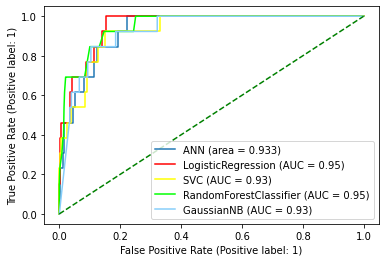

In [25]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
from sklearn.metrics import roc_curve
y_pred_keras = classifier.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

ax.plot(fpr_keras, tpr_keras, label='ANN (area = {:.3f})'.format(auc_keras))
log_disp = RocCurveDisplay.from_estimator(logistic, x_test, y_test, ax = ax, color = "red")
svc_disp = RocCurveDisplay.from_estimator(svc, x_test, y_test, ax = ax, color = "yellow")
rf_disp = RocCurveDisplay.from_estimator(rf, x_test, y_test, ax = ax, color = "lime")
gas_disp = RocCurveDisplay.from_estimator(gas, x_test, y_test, ax = ax, color = "lightskyblue")

plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.savefig('/content/drive/My Drive/부실기업예측 프로젝트/roc2.png')
plt.show()

In [26]:
# # Undersample and plot imbalanced dataset with One-Sided Selection
# # OSS 는 Tomec의 경계의 모호한 데이터를 삭제하면서 CNN의 결정경계에서 먼 데이터들을 삭제하는 두 모델의 종합니다
# from collections import Counter
# from sklearn.datasets import make_classification
# from imblearn.under_sampling import OneSidedSelection

# # summarize class distribution
# print(Counter(y_train))
# # define the undersampling method
# undersample = OneSidedSelection(n_neighbors=1, n_seeds_S=250,random_state=0)
# # transform the dataset
# x_under, y_under = undersample.fit_resample(x_train, y_train)
# # summarize the new class distribution
# print(Counter(y_under))


In [27]:
# Gausian(x_under,y_under,x_test,y_test)

In [28]:
# SVM_model(x_under,y_under,x_test,y_test)

In [29]:
# Logistic_model(x_under,y_under,x_test,y_test)

In [30]:
# ANN(x_under,y_under,x_test,y_test)

In [31]:
# RF_model(x_under,y_under,x_test,y_test)

In [32]:
# RandomSearch 각 모델별 시작 언더 샘플링 데이터를 활용
# Logistic

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import loguniform

logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200)
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['C'] = loguniform(1e-5, 100)
logistic_random = RandomizedSearchCV(logistic, space, n_iter=50, scoring='roc_auc', n_jobs=-1, random_state=0)
search = logistic_random.fit(x_under, y_under)
joblib.dump(logistic_random, "/content/drive/My Drive/부실기업예측 프로젝트/pred_model/random_logistic.h5")
search.best_params_

{'C': 0.7645719685939677, 'solver': 'lbfgs'}

In [33]:
# Logistic
result = search.predict(x_test)
print("Accuracy score :", accuracy_score(y_test, result), "ROC-AUC : ", roc_auc_score(y_test, result), "F1-score : ", f1_score(y_test, result))
print(confusion_matrix(y_test, result))
print(classification_report(y_test, result, labels=[0,1]))

Accuracy score : 0.8375634517766497 ROC-AUC :  0.9169550173010381 F1-score :  0.21311475409836067
[[482  96]
 [  0  13]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91       578
           1       0.12      1.00      0.21        13

    accuracy                           0.84       591
   macro avg       0.56      0.92      0.56       591
weighted avg       0.98      0.84      0.89       591



In [34]:
logistic_random.predict_proba(x_test)

array([[6.56894152e-01, 3.43105848e-01],
       [8.45565814e-01, 1.54434186e-01],
       [6.76473272e-05, 9.99932353e-01],
       ...,
       [7.56673902e-01, 2.43326098e-01],
       [8.57526131e-01, 1.42473869e-01],
       [5.07596743e-01, 4.92403257e-01]])

In [35]:
# SVM
svm = SVC(random_state=0)

# RANDOM SEARCH FOR 20 COMBINATIONS OF PARAMETERS
rand_list = {"C": uniform(2, 10),
             "gamma": uniform(0.1, 1)}        
rand_search = RandomizedSearchCV(svm, param_distributions = rand_list, n_iter = 50, n_jobs = -1, random_state = 0, scoring = "roc_auc") 
search = rand_search.fit(x_under,y_under)
joblib.dump(logistic_random, "/content/drive/My Drive/부실기업예측 프로젝트/pred_model/random_svm.h5")
search.best_params_

{'C': 2.710360581978869, 'gamma': 0.1871292997015407}

In [36]:
search.score(x_train,y_train)

0.939690898532362

In [37]:
result = search.predict(x_test)
print("Accuracy score :", accuracy_score(y_test, result), "ROC-AUC : ", roc_auc_score(y_test, result), "F1-score : ", f1_score(y_test, result))
print(confusion_matrix(y_test, result))
print(classification_report(y_test, result, labels=[0,1]))

Accuracy score : 0.7969543147208121 ROC-AUC :  0.8961937716262977 F1-score :  0.1780821917808219
[[458 120]
 [  0  13]]
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       578
           1       0.10      1.00      0.18        13

    accuracy                           0.80       591
   macro avg       0.55      0.90      0.53       591
weighted avg       0.98      0.80      0.87       591



In [38]:
rand_list = {'bootstrap': [True, False],
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = rand_list, n_iter = 50, verbose=2, random_state=0, n_jobs = -1, scoring = "roc_auc")
# Fit the random search model
search = rf_random.fit(x_under,y_under)
search.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 2000}

In [39]:
result = search.predict(x_test)
print("Accuracy score :", accuracy_score(y_test, result), "ROC-AUC : ", roc_auc_score(y_test, result), "F1-score : ", f1_score(y_test, result))
confusion_matrix(y_test, result)
print(classification_report(y_test, result, labels=[0,1]))

Accuracy score : 0.7377326565143824 ROC-AUC :  0.865916955017301 F1-score :  0.14364640883977903
              precision    recall  f1-score   support

           0       1.00      0.73      0.85       578
           1       0.08      1.00      0.14        13

    accuracy                           0.74       591
   macro avg       0.54      0.87      0.49       591
weighted avg       0.98      0.74      0.83       591



In [40]:
#가우시안
from sklearn.model_selection import GridSearchCV

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=2, n_jobs=-1,  scoring = "recall")
search = nbModel_grid.fit(x_under,y_under)
search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'var_smoothing': 1.0}

In [41]:
result = search.predict(x_test)
print("Accuracy score :", accuracy_score(y_test, result), "ROC-AUC : ", roc_auc_score(y_test, result), "F1-score : ", f1_score(y_test, result))
print(confusion_matrix(y_test, result))
print(classification_report(y_test, result, labels=[0,1]))

Accuracy score : 0.3553299492385787 ROC-AUC :  0.5952222517966462 F1-score :  0.05459057071960298
[[199 379]
 [  2  11]]
              precision    recall  f1-score   support

           0       0.99      0.34      0.51       578
           1       0.03      0.85      0.05        13

    accuracy                           0.36       591
   macro avg       0.51      0.60      0.28       591
weighted avg       0.97      0.36      0.50       591

